In [2]:
# imports
from tqdm import tqdm
import random
import os
import time
# Turn off tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

# For Data Processing & ML Models
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance
import cv2

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Enable offline usage of plotly
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

from IPython.display import clear_output
clear_output()


**For uniform results, random seed is required**

In [3]:
tf.random.set_seed(100)
np.random.seed(100)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 1. EDA

In [4]:
path = "/kaggle/input/cxr-for-cptn/Dataset/"
os.listdir(path)

['PNEUMONIA', 'TUBERCULOSIS', 'NORMAL', 'COVID-19']

## Distibution of data

In [5]:
# Define the directory paths
all_paths = []
all_labels = []
for label in os.listdir(path):
    label_dir = os.path.join(path, label)
    for image in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image)
        all_paths.append(image_path)
        all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'path':all_paths, 'label':all_labels})
df.head()

,path,label
0,/kaggle/input/cxr-for-cptn/Dataset/TUBERCULOSIS/Tuberculosis-185.png,TUBERCULOSIS
1,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1358_bacteria_3465.jpeg,PNEUMONIA
2,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0261-0001.jpeg,NORMAL
3,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person257_virus_538.jpeg,PNEUMONIA
4,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1644_bacteria_4357.jpeg,PNEUMONIA


In [6]:
print("shape of data:",df.shape)
print("------------------------------------")
print("Column names:", df.columns)

shape of data: (10172, 2)
------------------------------------
Column names: Index(['path', 'label'], dtype='object')


In [7]:
df['label'].value_counts()

PNEUMONIA       4273
COVID-19        3616
NORMAL          1583
TUBERCULOSIS     700
Name: label, dtype: int64

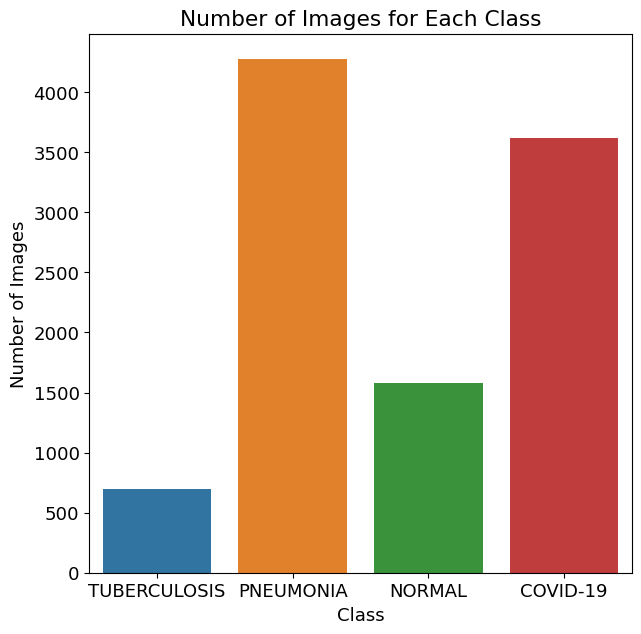

In [8]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
sns.countplot(x = df['label'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images for Each Class')
plt.show()

## Splitting the data into train, test and validation : 80%, 10% and 10%

It is generally recommended to split the data into train, test, and validation sets before preprocessing the data. This is because preprocessing techniques such as normalization, scaling, and feature selection are often based on the statistics of the training set, and applying these techniques before splitting the data can lead to data leakage and overfitting

In [9]:
from sklearn.model_selection import train_test_split
# Split the data into train and test sets with stratified sampling
train_val, test_df = train_test_split(df, test_size=0.1, stratify=df['label'], random_state=42)
# Split the train set into train and validation sets with stratified sampling
train_df, val_df = train_test_split(train_val, test_size=0.1, stratify=train_val['label'], random_state=42)

In [10]:
print("Original train+val set:", train_val.shape)
print("Train set:",train_df.shape)
print("Test set:",test_df.shape)
print("Val set:",val_df.shape)

Original train+val set: (9154, 2)
Train set: (8238, 2)
Test set: (1018, 2)
Val set: (916, 2)


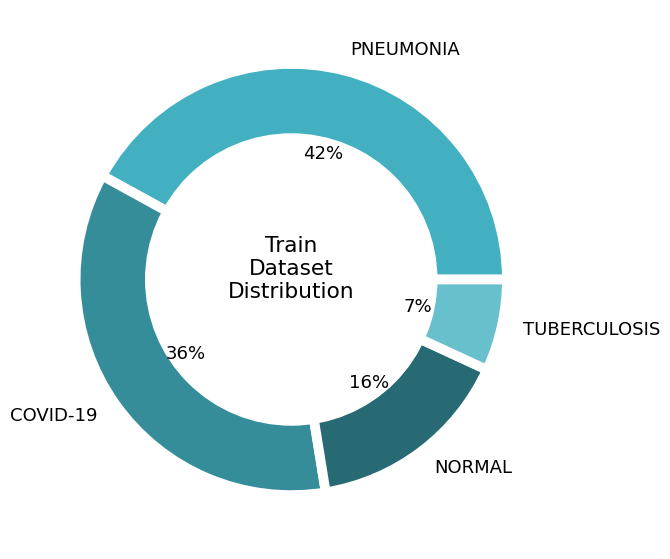

In [11]:
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(7,7))
# plotting data on chart
plt.pie(list(df.label.value_counts()),
        labels=list(train_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Train\nDataset\nDistribution', x=0.5, y=0.45) 
plt.show()

From the total dataset distribution, pneumonia images accounts for more that half of the dataset with 42% while tuberculosis instances accounts for only 7% ot the total dataset. Other classes for normal and Covid-19 accounts for 16% and 36% respectively. 

# 2. Pre-processing
Image Augmentation is a process that is used to create new images for training by slightly altering the pixel values.
We have a small dataset, so we can apply some image augmentation techniques to prevent overfitting of the model.
Techniques we will be using are:

1. Change the brightness of an image by a factor between 0.67 to 1.33
2. Change the contrast of an image by a factor between 0.67 to 1.33

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
class configurations:
    IMAGE_SIZE = 224
    BRIGHTNESS = (0.64, 1.37) # (MIN, MAX)
    CONTRAST = (0.64, 1.37) # (MIX, MAX)
    BATCH_SIZE = 32
    EPOCHS = 10
    LEARNING_RATE = 0.001
def augment_image(image):
    datagen = ImageDataGenerator(
        brightness_range=configurations.BRIGHTNESS,
        rescale = 1./255
        #contrast_range=configurations.CONTRAST,
        #horizontal_flip=True,
        #vertical_flip=True,
        #rotation_range=20,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2
    )
    # Convert input image from numpy to PIL Image
    image = np.expand_dims(image, axis=0)
    # Apply Transformations
    image = datagen.flow(image, batch_size=1)[0][0]
    return image

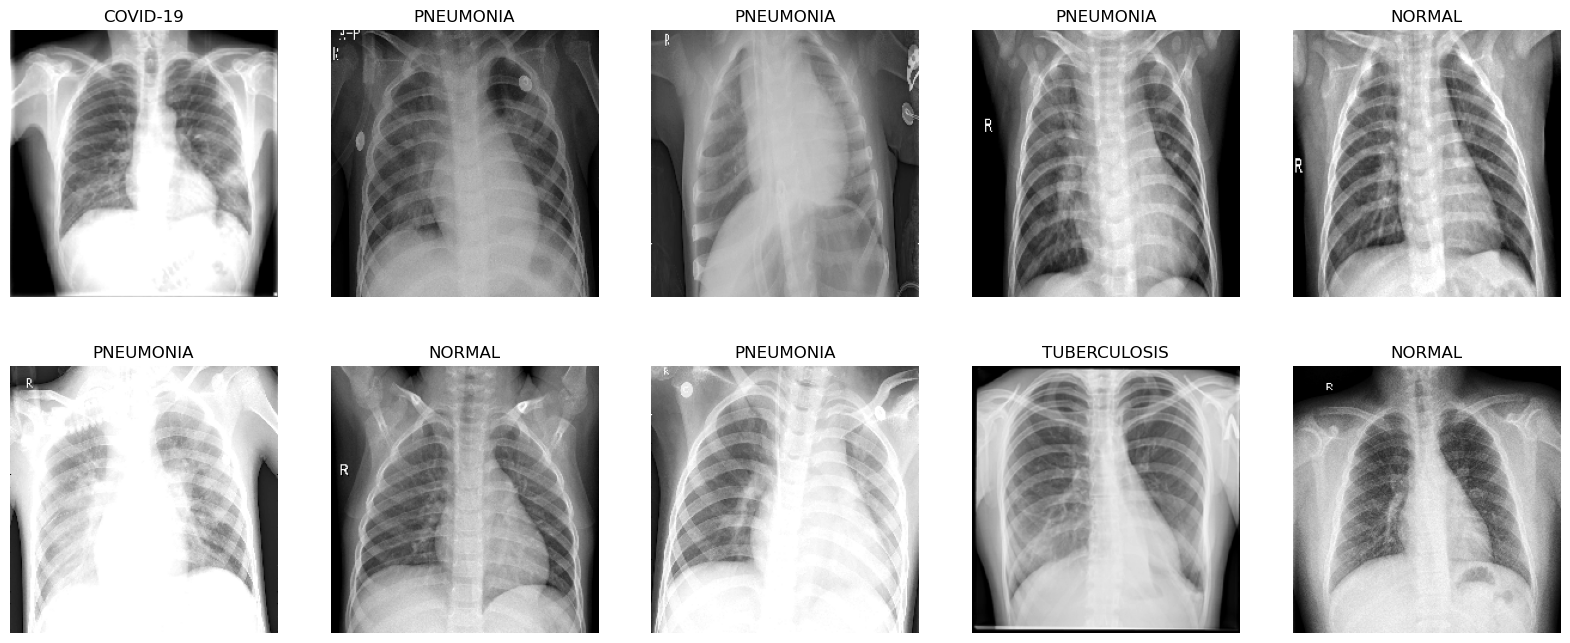

In [13]:
def open_images(paths, augment=True):
    '''
    Given a list of paths to images, this function returns the images as arrays, and conditionally augments them
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(configurations.IMAGE_SIZE,configurations.IMAGE_SIZE))
        if augment:
            image = augment_image(image)
        image = np.array(image)
        image = image/image.max()
        images.append(image)
    return np.array(images)

# Randomly select and plot a few images with augmentation
k = random.randint(0,5000)
image_paths = list(train_df.path[k:k+10])
labels = list(train_df.label[k:k+10])
images = open_images(image_paths, augment=True)
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(20, 8))

for i in range(0, 10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(labels[i])
plt.show()

## 2.1 Label encoder-decoder
1. Creating a dictionary label_encoder to convert string label to interger-encoded label
2. And another dictionary label_decoder to decode the integer-encoded label

In [14]:
LABELS = ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
label_encoder = {'NORMAL': 0, 'TUBERCULOSIS': 1, 'PNEUMONIA': 2, 'COVID-19': 3}
label_decoder = {0: 'NORMAL', 1: 'TUBERCULOSIS', 2: 'PNEUMONIA', 3: 'COVID-19'}

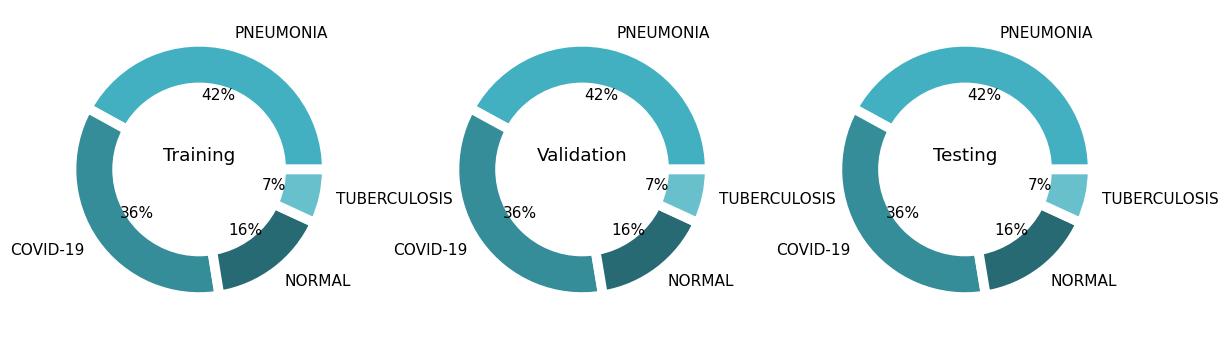

In [15]:
plt.rcParams.update({'font.size': 11})
fig = plt.figure(figsize=(14, 7))

fig.add_subplot(1, 3, 1)
plt.pie(list(train_df.label.value_counts()),
        labels=list(train_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Training', x=0.5, y=0.5) 


fig.add_subplot(1, 3, 2)
plt.pie(list(val_df.label.value_counts()),
        labels=list(val_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Validation', x=0.5, y=0.5) 

fig.add_subplot(1, 3, 3)
plt.pie(list(test_df.label.value_counts()),
        labels=list(test_df.label.value_counts().index),
        colors=['#43b0c1', '#368d9a', '#286a74', '#69c0cd'],
        autopct='%.0f%%', wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })

my_circle=plt.Circle((0,0), 0.675, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.axis('off')
plt.title('Testing', x=0.5, y=0.5) 
plt.show()

Training a model on this highly imbalanced dataset will cause the model to overfit on the class that is in excess and fail to learn patterns from other classes. Fortunately, there are ways to tackle this problem. What we will be doing is assigning "class weights" to the classes, to handle the imbalanced classes. This will be computed in the later sections

## 2.3 Data Generators
data_generator is the generator function which we will use for training. It has 4 input parameters:

1. > df: This is the dataframe containing the image paths and labels \n
1. > batch_size (int): Batch size of training samples
1. > augment (boolean): If true, the augmentation techniques defined before will be applied to the images. We will set this to True during training and False during validation
1. > epochs (int): Number of epochs

In [16]:
def data_generator(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [17]:
# Creating generators for training and validation. You can change the parameters in the configuration section.
train_data_generator = data_generator(train_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_steps = int(len(train_df)/configurations.BATCH_SIZE)

val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_steps = int(len(val_df)/configurations.BATCH_SIZE)

# 3. Model

## 3.1 Model architecture 
* We are utilizing the inspiration of ResNet-50 model

In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D,MaxPooling2D, Dropout, Flatten, Activation, Input, Add

In [19]:
resnet_model= ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
for layer in resnet_model.layers[:-10]:
    layers.trainable=False
hm = resnet_model.output
hm = AveragePooling2D(pool_size=(4,4))(hm)
hm = Flatten(name = 'flatten')(hm)
hm = Dense(256, activation = 'relu')(hm)
hm = Dropout(0.3)(hm)
hm = Dense(128, activation = 'relu')(hm)
hm = Dropout(0.2)(hm)
hm = Dense(4,activation = 'softmax')(hm)

model = Model(inputs=resnet_model.input, outputs = hm)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## 3.2 Compile

This is the loss function we will be using:  

$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [y_i\text{log}(\hat y_i) + (1-y_i)\text{log}(1-\hat y_i)]$$
where,  
$\quad\hat y$ is the predicted label, and $y$ is the actual label  
$\quad y_i$ is the $i^\mathbf{th}$ sample of $y$  and $\hat y_i$ is the $i^\mathbf{th}$ sample of $\hat y$  
$\quad N$ is the number of samples

`sparse_categorical_crossentropy` and `categorical_crossentropy` are basically the same loss functions, just their input formats are different.  
If $y_i$ is <b><mark>one-hot encoded</mark></b>, we use `categorical_crossentropy`, and if $y_i$ is <b><mark>integer-encoded</mark></b>, we use `sparse_categorical_crossentropy`  
For our case, the labels from the data generators are <b><mark>integer-encoded</mark></b>, so we are using `sparse_categorical_crossentropy`  

In [21]:
from tensorflow.keras.optimizers import SGD
sgd_optimizer = SGD(configurations.LEARNING_RATE)
model.compile(optimizer=sgd_optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

#model.compile(optimizer=optimizers.Adam(learning_rate=cfg.LEARNING_RATE),
#            loss='sparse_categorical_crossentropy',
#             metrics=['accuracy'])

# 3.3 Training the model

In this phase, we will use our dataset to train our model first without handling class imbalance problems and later, when handling the class imbalance problem using different approaches.

In [22]:
model_checkpoint_callback_imb = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model_imb.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

history_imb = model.fit(train_data_generator, epochs=configurations.EPOCHS, steps_per_epoch=train_steps,
          validation_data=val_data_generator, validation_steps=val_steps, callbacks=[model_checkpoint_callback_imb])

Epoch 1/10
257/257 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.7365
Epoch 1: val_accuracy improved from -inf to 0.36384, saving model to /kaggle/working/model_imb.hdf5
257/257 [==============================] - 125s 394ms/step - loss: 0.6887 - accuracy: 0.7365 - val_loss: 1.4889 - val_accuracy: 0.3638
Epoch 2/10
257/257 [==============================] - ETA: 0s - loss: 0.2588 - accuracy: 0.9092
Epoch 2: val_accuracy did not improve from 0.36384
257/257 [==============================] - 92s 352ms/step - loss: 0.2588 - accuracy: 0.9092 - val_loss: 1.6378 - val_accuracy: 0.1350
Epoch 3/10
257/257 [==============================] - ETA: 0s - loss: 0.1726 - accuracy: 0.9404
Epoch 3: val_accuracy improved from 0.36384 to 0.39732, saving model to /kaggle/working/model_imb.hdf5
257/257 [==============================] - 90s 350ms/step - loss: 0.1726 - accuracy: 0.9404 - val_loss: 1.6617 - val_accuracy: 0.3973
Epoch 4/10
257/257 [==============================] - E

**Evaluate the performance**

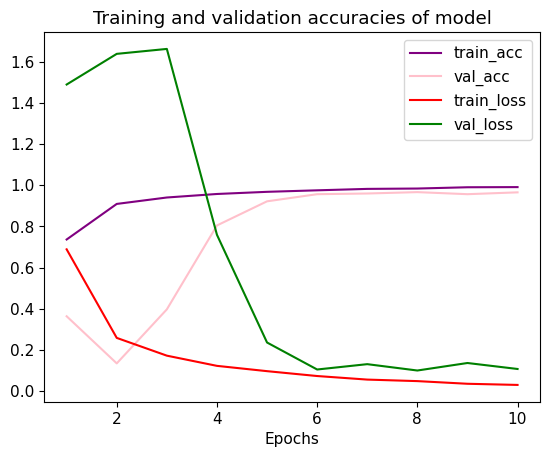

In [23]:
epochs_imb = range (1, len(history_imb.history['accuracy']) + 1)
plt.plot(epochs_imb, history_imb.history['accuracy'], color = 'purple')
plt.plot(epochs_imb, history_imb.history['val_accuracy'], color = 'pink')
plt.plot(epochs_imb, history_imb.history['loss'], color = 'red')
plt.plot(epochs_imb, history_imb.history['val_loss'], color = 'green')
plt.xlabel('Epochs')
plt.ylabel('')
plt.title('Training and validation accuracies of model')
plt.legend(["train_acc","val_acc","train_loss","val_loss"], loc = "upper right")
plt.show()

From the plot, the accuracy of our model rises from the first epoch until it reaches the maximum point of 0.99. The validation accuracy of the model reaches highest of 0.96. Both the training loss and validation loss shows a downward trend in both the train and validation set. To evaluate its performance across the 4 classes, we can look at the classification report of our model that shows the precision, recall and F1-score performances.

In [24]:
val_data_generator_imb = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
val_steps_imb = int(len(val_df)/configurations.BATCH_SIZE)

y_pred_imb = []
y_true_imb = []

for x,y in tqdm(val_data_generator_imb, total=val_steps_imb):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred_imb.append(label_decoder[i])
    for i in y:
        y_true_imb.append(label_decoder[i])
clear_output()
print(classification_report(y_true_imb, y_pred_imb, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9700    0.9908    0.9803       326
      NORMAL     0.8947    0.9577    0.9252       142
   PNEUMONIA     0.9813    0.9558    0.9684       385
TUBERCULOSIS     0.9643    0.8571    0.9076        63

    accuracy                         0.9618       916
   macro avg     0.9526    0.9404    0.9454       916
weighted avg     0.9627    0.9618    0.9617       916



### **Interpretation of these results**

The results gives a confusion matrix/classification report of the covid-tuberculosis-pneumonia-normal dataset.The detailed description is shown as:

    1. Precision - Describes number of predicted positive instances that are actually true positive. A high precision indicates that the model has low rate of false positives. From the 4 classes in the dataset, our model shows good recall of above .95
    
    2. Recall - measures how many actual positive instances were correctly predicted by the model. High recall indicates the model is good at capturing positive instances. The recall for covid-19 and tuberculosis instances are slightly high compared to the other two classes. 
    
    3. F1-score - Describes the harmonic mean of precision and recall. It provides a balanced measure between precision and recall and it's a good metric for the imbalanced dataset, like ours. A high F1-score indicates a good balance between precision and recall. Our model has a good F1-score where all classes have a score above .9
    
    The overall accuracy of the model is 96.51 which is a good performance for the model on the dataset.
    
    In this problem, both false positives and false negatives are equally important .
    
    False Negatives - These occur when the model predicts a negative class (e.g., "NORMAL" in a medical context) when it should have predicted a positive class (e.g., "COVID-19"). False negatives can be particularly problematic in situations where missing a positive case could have severe consequences. For instance, in medical diagnoses, failing to identify a disease like COVID-19 could lead to delayed treatment and potential harm to the patient.
    
    False Positives - These happen when the model predicts a positive class when it should have predicted a negative class. In medical scenarios, this could lead to unnecessary treatments, tests, or alarms, causing inconvenience and potential costs to patients and healthcare providers.
    
    As a result, the most important evaluation metric for our data is F1-score 

## Training models by handling class imbalance

## 1. Handling class imbalance with class weighting approach

With class weighting approach, we use class weights to tackle the imbalanced dataset problem. Using our loss function, the cross-entropy loss function, we will create a bias towards the dominating class. So, we will apply multipliers, or 'weights' to balance the loss function. This is called a <b><mark>weighted loss function</mark></b>:  
$$\mathcal{L}_{cross-entropy} = -\cfrac{1}{N}\sum_{i=1}^N [w_p y_i\text{log}(\hat y_i) + w_n (1-y_i)\text{log}(1-\hat y_i)]$$

So how do we calculate these so called weights $w_p$ and $w_n$ for each class? Just calculate the proportion of the dataset each class represents and tensorflow will handle the rest.  
`class_weights` is a dictionary of format `{'CLASS':'PROPORTION'}`

In [25]:
class_weights = (train_df.label.value_counts() / len(train_df)).to_dict()
class_weights = dict((label_encoder[key], value) for (key, value) in class_weights.items())
class_weights

{2: 0.420004855547463,
 3: 0.35542607428987616,
 0: 0.15574168487496964,
 1: 0.06882738528769118}

Text(0.5, 1.0, 'Class Weights for Each Class')

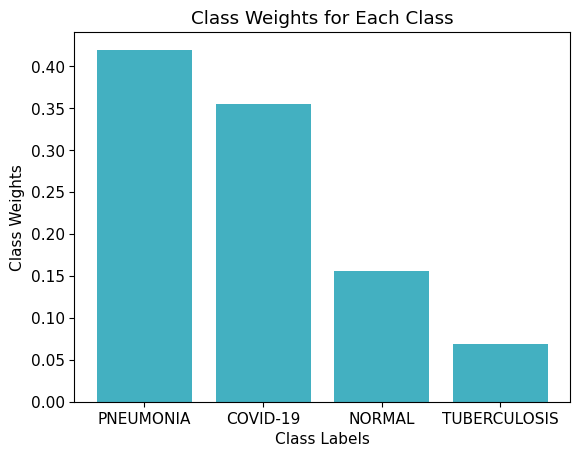

In [26]:
# distribution of the class weights
class_labels_w = [label_decoder[label] for label in class_weights.keys()]
weights = list(class_weights.values())

plt.bar(class_labels_w, weights, color='#43b0c1')
plt.xlabel('Class Labels')
plt.ylabel('Class Weights')
plt.title('Class Weights for Each Class')

In [31]:
# generator for class_weighting
def data_generator_weighting(df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS):
    for e in range(epochs):
        for x in range(0,len(df), batch_size):
            image_paths = df.path[x:x+batch_size]
            images = open_images(image_paths, augment=augment)
            labels = df.label[x:x+batch_size]
            labels = [label_encoder[label] for label in labels]
            yield images, np.array(labels)

In [32]:
train_data_generator_weighting = data_generator_weighting(train_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
train_steps_weighting = int(len(train_df)/configurations.BATCH_SIZE)

val_data_generator_weighting = data_generator_weighting(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
val_steps_weighting = int(len(val_df)/configurations.BATCH_SIZE)

In [34]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience = 5)

history = model.fit(train_data_generator_weighting, epochs=configurations.EPOCHS, steps_per_epoch=train_steps_weighting,
          validation_data=val_data_generator_weighting, validation_steps=val_steps_weighting,class_weight = class_weights, callbacks=[model_checkpoint_callback, early_stopping])

Epoch 1/10
257/257 [==============================] - ETA: 0s - loss: 0.0055 - accuracy: 0.9912
Epoch 1: val_accuracy improved from -inf to 0.96429, saving model to /kaggle/working/model.hdf5
257/257 [==============================] - 92s 358ms/step - loss: 0.0055 - accuracy: 0.9912 - val_loss: 0.1076 - val_accuracy: 0.9643
Epoch 2/10
257/257 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9934
Epoch 2: val_accuracy improved from 0.96429 to 0.96652, saving model to /kaggle/working/model.hdf5
257/257 [==============================] - 87s 339ms/step - loss: 0.0050 - accuracy: 0.9934 - val_loss: 0.1150 - val_accuracy: 0.9665
Epoch 3/10
257/257 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9935
Epoch 3: val_accuracy did not improve from 0.96652
257/257 [==============================] - 89s 347ms/step - loss: 0.0052 - accuracy: 0.9935 - val_loss: 0.1090 - val_accuracy: 0.9665
Epoch 4/10
257/257 [==============================] - ETA: 0s - 

# 4. Evaluate the model

In [35]:
val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
val_steps = int(len(val_df)/configurations.BATCH_SIZE)

y_pred = []
y_true = []

for x,y in tqdm(val_data_generator, total=val_steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(label_decoder[i])
    for i in y:
        y_true.append(label_decoder[i])
clear_output()
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9673    0.9969    0.9819       326
      NORMAL     0.9172    0.9366    0.9268       142
   PNEUMONIA     0.9764    0.9662    0.9713       385
TUBERCULOSIS     0.9815    0.8413    0.9060        63

    accuracy                         0.9640       916
   macro avg     0.9606    0.9353    0.9465       916
weighted avg     0.9643    0.9640    0.9637       916



# 5. Conclusion and Deployment

1/1 [==============================] - 0s 431ms/step


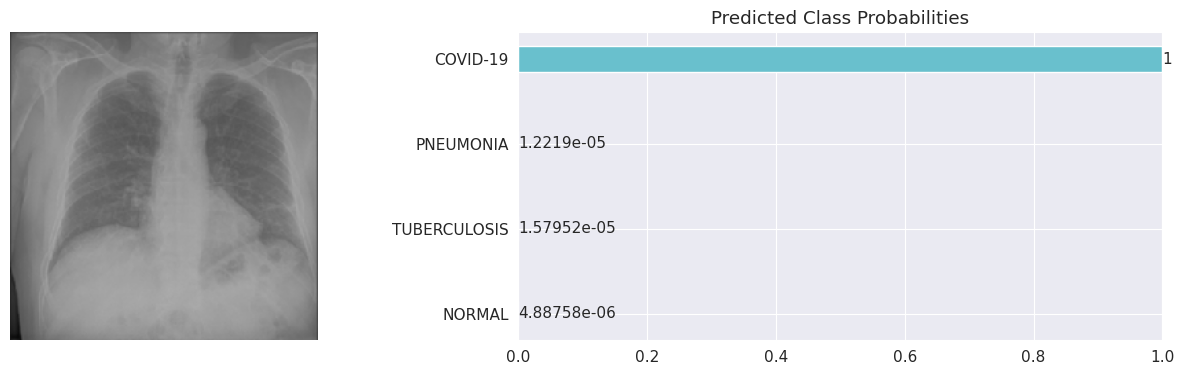

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


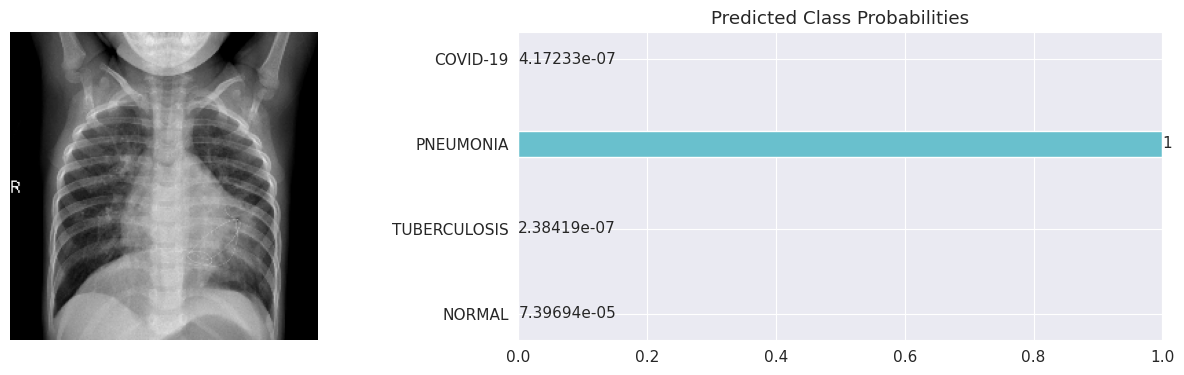

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 27ms/step


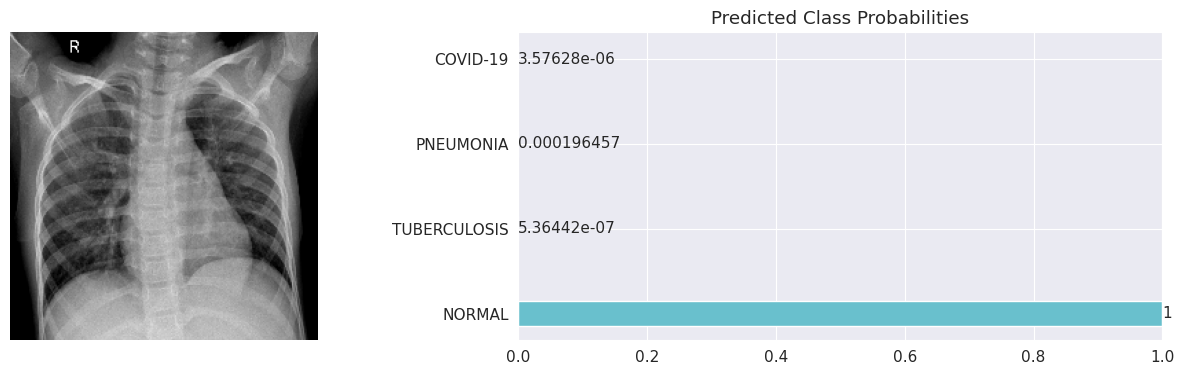

Actual   : NORMAL
Predicted: NORMAL
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 32ms/step


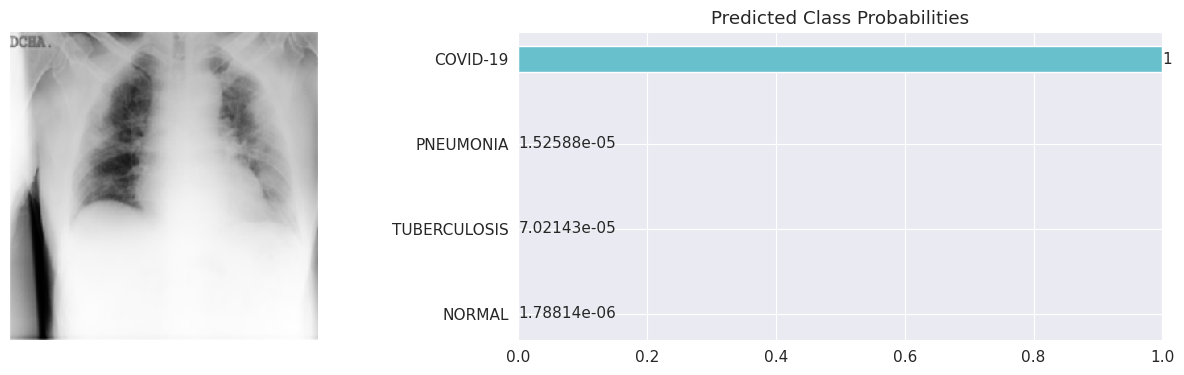

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


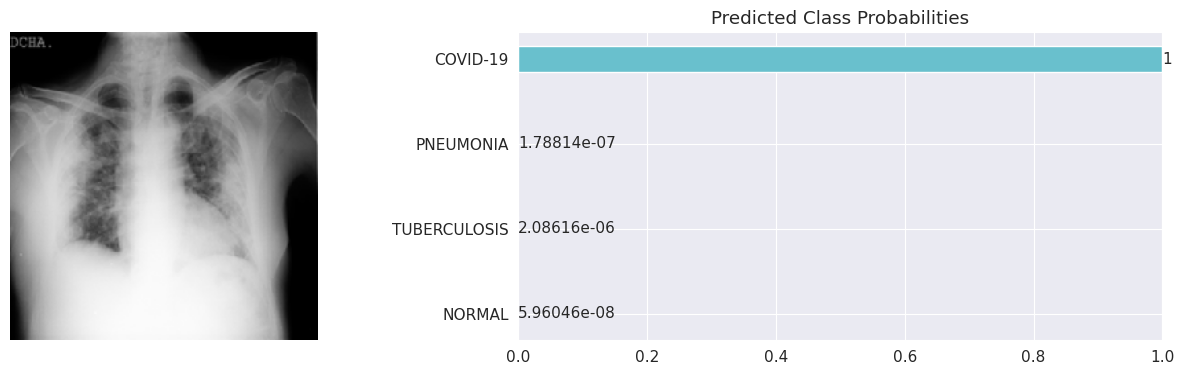

Actual   : COVID-19
Predicted: COVID-19
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 24ms/step


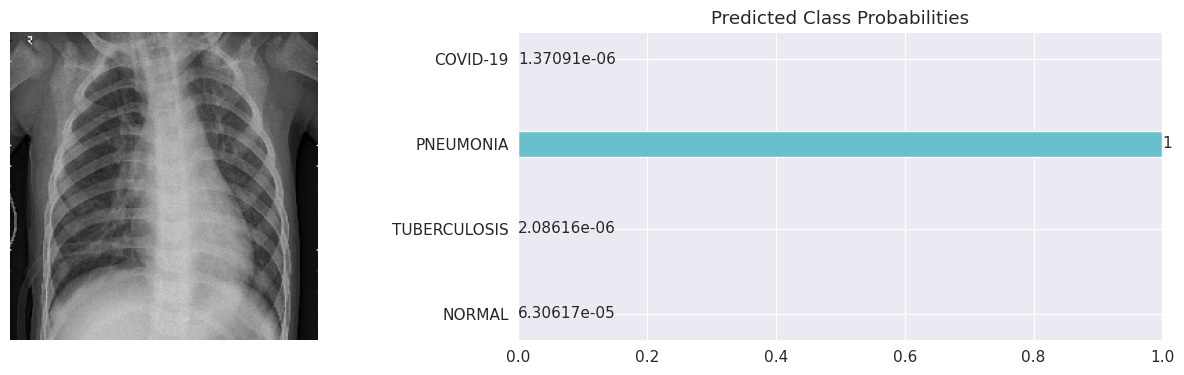

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------


1/1 [==============================] - 0s 26ms/step


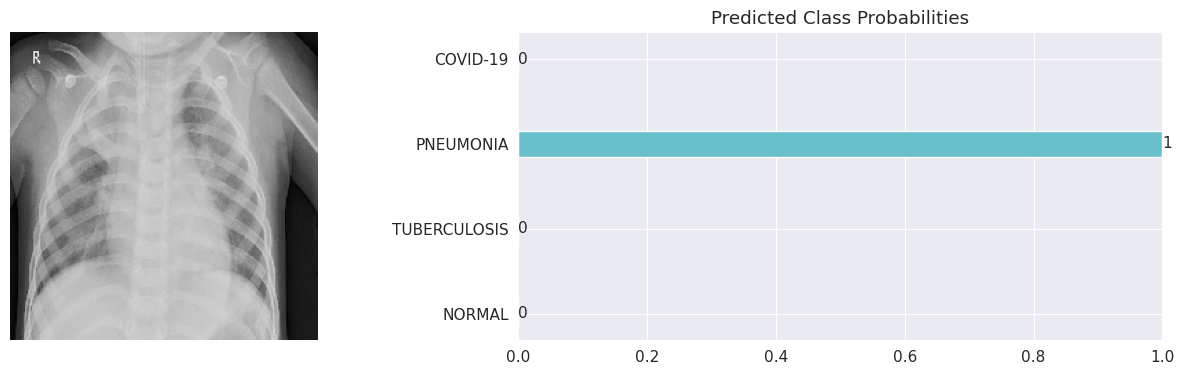

Actual   : PNEUMONIA
Predicted: PNEUMONIA
--------------------------------------------------------------------------------




In [36]:
def predict(image, model):
    '''
    Input the image and model, this function outputs the prediction as:
        1. The class with the highest probability
        2. A dictionary containing each class with their corresponding probability
    '''
    labels =  ['NORMAL', 'TUBERCULOSIS', 'PNEUMONIA', 'COVID-19']
    image = np.array(image)
    image = image/image.max()
    image = image.reshape(-1,configurations.IMAGE_SIZE,configurations.IMAGE_SIZE,3)
    probabilities = model.predict(image).reshape(-1)
    pred = labels[np.argmax(probabilities)]
    return pred, {x:y for x,y in zip(labels, probabilities)}

INDICES = random.sample(list(train_df.index), 7)

for INDEX in INDICES:

    image = load_img(train_df.path[INDEX], target_size=(configurations.IMAGE_SIZE, configurations.IMAGE_SIZE))
    pred, probabilities = predict(image, model)

    x = list(probabilities.keys())
    y = list(probabilities.values())

    sns.set_style("darkgrid")
    fig, ax = plt.subplots(1,2, figsize=(16,4), gridspec_kw={'width_ratios': [3, 4]})
    ax[0].imshow(image)
    ax[0].axis('off')

    bars = ax[1].barh(x, y, height=0.3, color=['#69c0cd', '#69c0cd', '#69c0cd', '#69c0cd'])
    ax[1].bar_label(bars)
    
    ax[1].set_title('Predicted Class Probabilities')
    plt.xlim([0, 1])
    plt.show()

    print('Actual   :',train_df.label[INDEX])
    print('Predicted:', pred)
    print('-'*80)
    print('\n')

## 2. Handling class imbalance by Oversampling the minority classes (through duplications)

The approach involves creating new samples of data by duplicating the minority class to balance the distribution. Unlike SMOTE, synthetic samples of data are duplicated based on data space while SMOTE creates synthetic samples based on feature space.

In [37]:
train_df.head(2)

,path,label
6007,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0283-0001.jpeg,NORMAL
2593,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/IM-0650-0001-0001.jpeg,NORMAL


<Axes: >

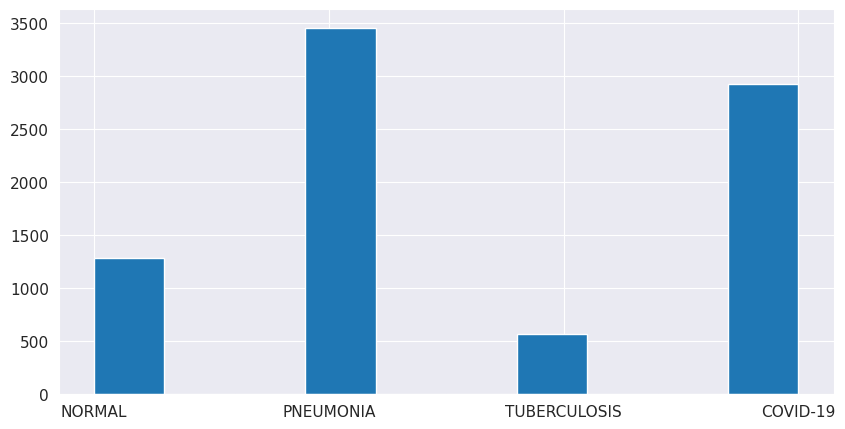

In [38]:
train_df['label'].hist(figsize = (10, 5))

In [39]:
train_df.pivot_table(index = 'label', aggfunc = len)

,path
label,
COVID-19,2928
NORMAL,1283
PNEUMONIA,3460
TUBERCULOSIS,567


**Data balancing**

Specifically, we create a function 'balance_data' to balance the training data by oversampling the minority class so that all classes have the same number of images as the maximum class. This is done to prevent the model from becoming biased towards the majority class and to improve overall classification performance.The function groups the data by label and then samples each group with replacement to create a new dataset with balanced classes. The resulting dataset is then shuffled and returned

In [40]:
def balance_data(class_size,df):
    train_df = df.groupby(['label']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['label'].hist(figsize = (10, 5))
    return train_df

New Data Size: 13840 Old Size: 8238


<Axes: >

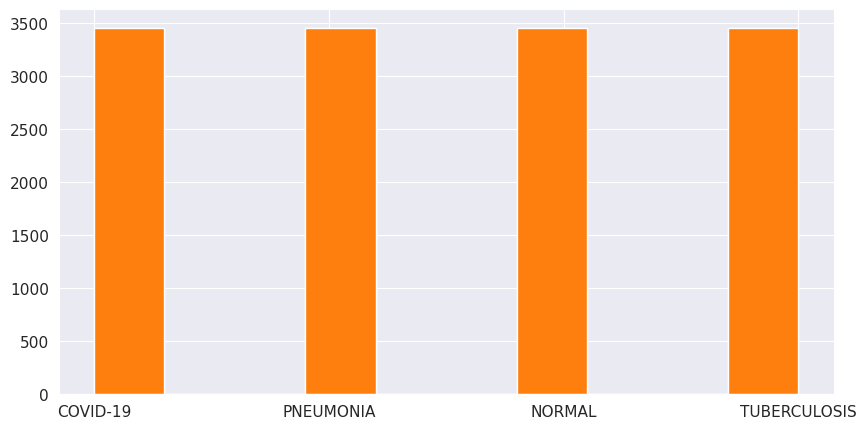

In [41]:
training_df = balance_data(train_df.pivot_table(index='label', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
training_df['label'].hist(figsize = (10, 5))

In [42]:
training_df.head()

,path,label
0,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-2905.png,COVID-19
1,/kaggle/input/cxr-for-cptn/Dataset/PNEUMONIA/person1881_bacteria_4767.jpeg,PNEUMONIA
2,/kaggle/input/cxr-for-cptn/Dataset/COVID-19/COVID-2349.png,COVID-19
3,/kaggle/input/cxr-for-cptn/Dataset/NORMAL/NORMAL2-IM-1305-0001.jpeg,NORMAL
4,/kaggle/input/cxr-for-cptn/Dataset/TUBERCULOSIS/Tuberculosis-171.png,TUBERCULOSIS


In [43]:
training_df['label'].value_counts()

COVID-19        3460
PNEUMONIA       3460
NORMAL          3460
TUBERCULOSIS    3460
Name: label, dtype: int64

In [44]:
# Create data for modeling
bal_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/bal_model.hdf5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose=1,
    save_best_only=True)

bal_training_data= data_generator(training_df, batch_size=configurations.BATCH_SIZE, augment=True, epochs=configurations.EPOCHS)
bal_train_steps = int(len(training_df)/configurations.BATCH_SIZE)
bal_val_data_generator = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=configurations.EPOCHS)
bal_val_steps = int(len(val_df)/configurations.BATCH_SIZE)

bal_history = model.fit(bal_training_data, epochs=configurations.EPOCHS, steps_per_epoch=train_steps,
          validation_data=bal_val_data_generator, validation_steps=bal_val_steps, callbacks=[bal_model_checkpoint_callback])

Epoch 1/10
257/257 [==============================] - ETA: 0s - loss: 0.0671 - accuracy: 0.9781
Epoch 1: val_accuracy improved from -inf to 0.94085, saving model to /kaggle/working/bal_model.hdf5
257/257 [==============================] - 105s 409ms/step - loss: 0.0671 - accuracy: 0.9781 - val_loss: 0.2366 - val_accuracy: 0.9408
Epoch 2/10
257/257 [==============================] - ETA: 0s - loss: 0.0377 - accuracy: 0.9884
Epoch 2: val_accuracy improved from 0.94085 to 0.95647, saving model to /kaggle/working/bal_model.hdf5
257/257 [==============================] - 106s 414ms/step - loss: 0.0377 - accuracy: 0.9884 - val_loss: 0.1498 - val_accuracy: 0.9565
Epoch 3/10
257/257 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.9946
Epoch 3: val_accuracy improved from 0.95647 to 0.96763, saving model to /kaggle/working/bal_model.hdf5
257/257 [==============================] - 104s 406ms/step - loss: 0.0202 - accuracy: 0.9946 - val_loss: 0.1285 - val_accuracy: 0.9676
E

In [45]:
bal_val_data_generator1 = data_generator(val_df, batch_size=configurations.BATCH_SIZE, augment=False, epochs=1)
bal_val_steps = int(len(val_df)/configurations.BATCH_SIZE)

y_pred1 = []
y_true1 = []

for x,y in tqdm(bal_val_data_generator1, total=bal_val_steps):
    pred1 = model.predict(x)
    pred1 = np.argmax(pred1, axis=-1)
    for i in pred1:
        y_pred1.append(label_decoder[i])
    for i in y:
        y_true1.append(label_decoder[i])
clear_output()
print(classification_report(y_true1, y_pred1, digits=4))

              precision    recall  f1-score   support

    COVID-19     0.9908    0.9908    0.9908       326
      NORMAL     0.9493    0.9225    0.9357       142
   PNEUMONIA     0.9717    0.9818    0.9767       385
TUBERCULOSIS     0.9524    0.9524    0.9524        63

    accuracy                         0.9738       916
   macro avg     0.9660    0.9619    0.9639       916
weighted avg     0.9737    0.9738    0.9737       916



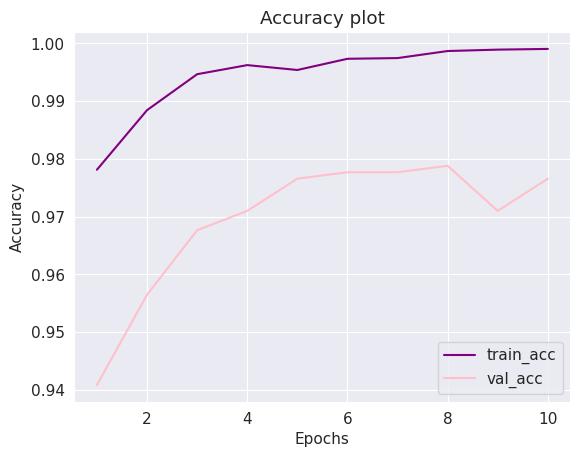

In [46]:
epochs = range (1, len(bal_history.history['accuracy']) + 1)
plt.plot(epochs, bal_history.history['accuracy'], color = 'purple')
plt.plot(epochs, bal_history.history['val_accuracy'], color = 'pink')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.legend(["train_acc","val_acc"])
plt.show()

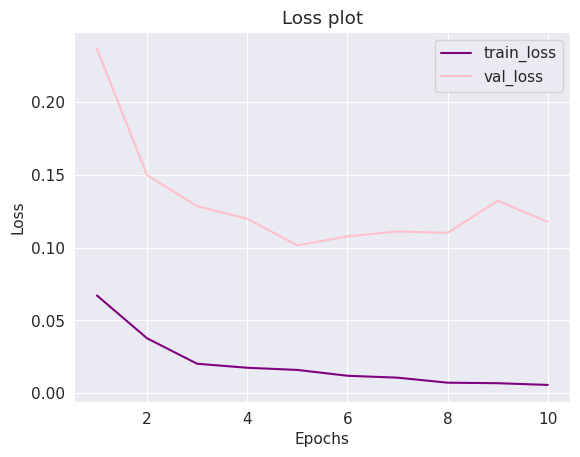

In [47]:
plt.plot(epochs, bal_history.history['loss'], color = 'purple')
plt.plot(epochs, bal_history.history['val_loss'], color = 'pink')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss plot")
plt.legend(["train_loss","val_loss"])
plt.show()